In [4]:
import copy
import numpy as np
from random import randrange, seed
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.animation import FuncAnimation

plt.style.use(['dark_background'])
plt.rc('animation', html='html5')


anim_size = (15, 9) # dimensions of animation


def set_nucleation_sites(init_state, number_of_sites):
    """Choose a number of random cells to nuleate from and return the
    nucleated state"""

    seed(1)
    size_y, size_x = init_state.shape
    for i in range(number_of_sites):
        # Don't allow sites to be on edges to reduce the number of
        # edge case if-else statements in growth function
        rand_x = randrange(1, size_x)
        rand_y = randrange(1, size_y)
        init_state[rand_y, rand_x] = sol

    return init_state


def display_state(state):
    """Show resulting image plot"""
    
    state = np.array(state)
    plt.figure(figsize=(20,20))
    plt.imshow(state[np.newaxis])
    format_imshow(plt.gca())


def format_imshow(ax):
    """Removes tickmarks from image, preserving black outline and
    changes colour sheme to blue"""

    plt.set_cmap('Blues_r')
    plt.xticks([])
    plt.xticks([], minor=True)
    plt.yticks([])
    plt.yticks([], minor=True)


def format_line_plot(ax, n_frames):
    """Formats % soldification line plot"""

    ax.set_xlabel('Timestep', size=20)
    ax.set_ylabel('% Solid', size=20)
    ax.set_ylim([0, 1.05])
    ax.set_xlim([0, n_frames-1])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    formatter = ticker.PercentFormatter(xmax=1)
    ax.yaxis.set_major_formatter(formatter)


def animate_growth(prev_states, col_grad=False, fps=0.02):
    """Animate simulation by showing three different graphics:
    the state of the simulation at an instant (i.e. 1D row of cells),
    the state of the simulation with time as the vertical axis (2D image
    of cells), and extent of solification at a given timestep (a line
    of amount solidified vs. time). A gif of the animation is saved as
    simulation_anim_1D.gif.

    Parameters
    ----------
    prev_states : list
        Nested list of shape (m, n) where m is the number of simulation
        timesteps/frame and n is the number of simulation cells
    col_grad : bool, optional
        Use a color gradient when making animation, by default False
    """

    prev_states = np.array(prev_states)
    fig = plt.figure(figsize=anim_size)

    divs=11 # number of vertical partitions for graphics
    n_frames, _ = prev_states.shape # Number of animation frames
    if col_grad: vmax=n_frames//10+1
    else: vmax=None

    # Simulation at an instant - initializing animation
    ax_sim_1D = plt.subplot2grid((divs,2),(0, 0))
    format_imshow(ax_sim_1D)
    sim_1D_frame_init = prev_states[0][np.newaxis]
    sim_1D_img = ax_sim_1D.imshow(sim_1D_frame_init,
                                  aspect='equal',
                                  animated=True,
                                  vmin=0,
                                  vmax=vmax)

    # Overall simulation as a 2D plot of states (horizontal) and time
    # (vertical)

    # prev_states is a 2D image where every row is the next timestep
    # in the simulation, i.e. a static image showing how the simulation
    # progressed. To animate, a semi-empty image is created for each
    # frame in the animation. Rows are progressivley copied from
    # prev_state to make a collection of frames that 'reveal' the
    # simulation as the animation runs
    sim_2D_frames = []
    sim_2D_frame_empty = np.zeros_like(prev_states)
    for i in range(n_frames):
        sim_2D_frame_empty[i] = prev_states[i]
        sim_2D_frames.append(copy.deepcopy(sim_2D_frame_empty))

    ax_sim_2D = plt.subplot2grid((divs,2),(1, 0), rowspan=divs-1)
    format_imshow(ax_sim_2D)
    sim_2D_frame_init = sim_2D_frames[0]
    # sim_2D_img = ax_sim_2D.imshow(sim_2D_frame_init, aspect='auto')
    sim_2D_img = ax_sim_2D.imshow(sim_2D_frame_init, animated=True,
                                  vmin=0, vmax=vmax)

    # Create line plot of the amount solidified
    size = len(prev_states[0])
    state_sol_count = np.sum(np.array(prev_states), axis=1)
    state_sol_fraction = state_sol_count / size

    ax_sol_frac = plt.subplot2grid((divs,2),(0, 1), rowspan=divs)
    sol_frac_line, = ax_sol_frac.plot([],[])
    format_line_plot(ax_sol_frac, n_frames)

    fig.tight_layout()

    def draw_frame(frame_num, col_grad=False):
        """Guides how animation is drawn based on the frame number.
        col_grad indicates whether a color gradient is used to the
        animation of the solidification"""

        if col_grad:
            sim_1D_img.set_array(np.sum(prev_states[:frame_num][np.newaxis], axis=1))
            sim_2D_img.set_array(np.sum(np.array(sim_2D_frames)[:frame_num], axis=0))
        else:
            sim_1D_img.set_array(prev_states[frame_num][np.newaxis])
            sim_2D_img.set_array(sim_2D_frames[frame_num])

        sol_frac_line.set_data(list(range(frame_num+1)), 
                               state_sol_fraction[:frame_num+1])

    # Create animation
    ani = FuncAnimation(fig, draw_frame, frames=n_frames, interval=n_frames/fps)
    # plt.show()
    # ani.save('simulation_anim_1D.gif')
    plt.close()

    return HTML(ani.to_html5_video())


def animate_growth_2D(prev_states, col_grad=False, fps=0.2):
    """Animate simulation by showing 2 different graphics: 1. the state
    of the simulation at an instant (2D image) where the lighter the
    shade the blue the 'older' the point of soldification and 2.
    the extent of solification at a given timestep (a line of amount
    solidified vs. time). A gif of the animation is saved as
    simulation_anim_2D.gif

    Parameters
    ----------
    prev_states : list
        List m arrays of shape (n, o)
    col_grad : bool, optional
        Use a color gradient when making animation, by default False
    """

    prev_states = np.array(prev_states)
    fig = plt.figure(figsize=anim_size)

    n_frames, _, _ = prev_states.shape
    if col_grad: vmax=n_frames//10+1
    else: vmax=None 

    # Simulation at in instant - initializing animation
    ax_sim_2D = plt.subplot2grid((1,2),(0, 0))
    format_imshow(ax_sim_2D)
    sim_2D_img = ax_sim_2D.imshow(prev_states[0], animated=True,
                                  vmin=0, vmax=vmax)

    # Create line plot of amount solidified
    size = prev_states[0].size
    state_solid_count = np.array([np.sum(i) for i in prev_states])
    state_solid_fraction = state_solid_count / size

    ax_sol_frac = plt.subplot2grid((1,2),(0, 1))
    sol_frac_line, = ax_sol_frac.plot([],[])
    format_line_plot(ax_sol_frac, n_frames)

    fig.tight_layout()

    def draw_frame(frame_num, col_grad=False):
        """Guides how animation is drawn based on the frame number.
        col_grad indicates whether a color gradient is used to the
        animation of the solidification"""

        if col_grad:
            sim_2D_img.set_array(np.sum(prev_states[:frame_num], axis=0))
        else:
            sim_2D_img.set_array(prev_states[frame_num])

        sol_frac_line.set_data(list(range(frame_num)),
                               state_solid_fraction[:frame_num])

    # Create animation
    ani = FuncAnimation(fig, draw_frame, interval=n_frames/fps,
                        frames=prev_states.shape[0])
    # ani.save('simulation_anim_2D.gif')
    plt.close()
    return HTML(ani.to_html5_video())

In [5]:
# Define discrete states for the system
liq = 0
sol = 1

In [6]:
# Define size and initial state of system
size = 10
state = [liq] * size
state[1] = sol

In [7]:
# What the current state of the system looks like as a list
state

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

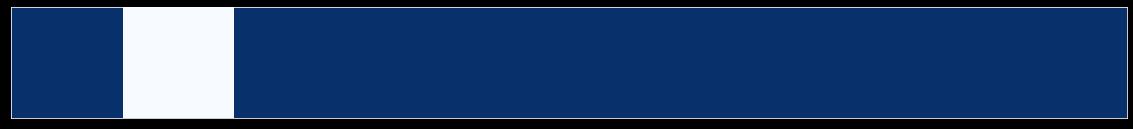

In [8]:
# Display the system as a 
display_state(state)

In [9]:
# Create cellular automata algorithm
prev_states = []
temp_state = copy.deepcopy(state)
prev_states.append(state)

while sum(temp_state) < len(state):
    for x in range(size):
        if x == 0:
            if state[x+1] == sol:
                temp_state[x] = sol
        elif x == len(state)-1:
            if state[x-1] == sol:
                temp_state[x] = sol
        elif state[x-1]==1 or state[x+1]==1:
            temp_state[x] = sol
    state = copy.deepcopy(temp_state)
    prev_states.append(state)

In [10]:
# Show results of simulation
animate_growth(prev_states)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [ ]:
# Same thing for 2 dimensions
size = 100
state = np.zeros((size, size))
state = set_nucleation_sites(state, 10)
temp_state = copy.deepcopy(state)
prev_states = []
while np.sum(state) < size*size:
    for x in range(size):
        for y in range(size):
            if state[y,x] == sol:
                    temp_state[y-1:y+2, x-1:x+2] = sol

    state = copy.deepcopy(temp_state)
    prev_states.append(copy.deepcopy(temp_state))

NameError: name 'np' is not defined

In [ ]:
prev_states

NameError: name 'prev_states' is not defined

In [ ]:
animate_growth_2D(prev_states)

MovieWriter ffmpeg unavailable; using Pillow instead.
